In [72]:
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import click

import sys
if 'SuperBoL' not in sys.path:
    sys.path.append('SuperBoL')
import superbol
from superbol.fit_blackbody import bb_fit_parameters, bb_flux_nounits
from superbol.fbol import (ir_correction, uv_correction_blackbody,
                           uv_correction_linear)

from astropy.cosmology import Planck15 as cosmo
import astropy.constants as const

redshift = 0.0159
dist = cosmo.luminosity_distance(redshift).to(u.cm)
dist_cm = dist.value
dist_pc = dist.to(u.pc).value
dist_mod = 5*np.log10(dist_pc) - 5


In [4]:
# data for SN 2004aw

obs = [
    # UBVRI from NOT
    ('U', 3617.41, 595.75, 3.97645e-9, 20.91, 0.06),
    ('B', 4346.66, 1013.59, 6.30566e-9, 19.96, 0.06),
    ('V', 5417.18, 891.04, 3.78699e-9, 18.35, 0.03),
    ('R', 6464.12, 1230.80, 2.26888e-9, 17.61, 0.03),
    ('I', 8682.26, 2955.82, 9.66006e-10, 17.00, 0.03),
    # JHK from TNG+NICS
    ('J', 12789.08, 2965.63, 2.87698e-10, 16.25, 0.09),
    ('H', 16288.24, 2963.05, 1.20622e-10, 15.99, 0.14),
    ('K', 22038.01, 3378.31, 4.0487e-11, 15.95, 0.13)
]
cent_wave = [x[1] for x in obs]
fwhm = [x[2] for x in obs]
zero_flux = [x[3] for x in obs]
#mags = [x[4] for x in obs]

#flux = zero_flux*10**(-0.4*np.array(mags))

In [15]:
# TODO: refactor that into a common location
EXTINCTION_COEFF = {
    'g': 3.303,
    'r': 2.285,
    'i': 1.698,
    'z': 1.263,
    # from https://irsa.ipac.caltech.edu/workspace/TMP_3mtiHn_9142/DUST/SN2004aw.v0001/extinction.html
    'U': 4.107,
    'B': 3.641,
    'V': 2.682,
    'R': 2.119,
    'I': 1.516,
    'J': 0.723,
    'H': 0.460,
    'K': 0.310
}
ebv = 0.37 # from lyman paper

mags_d = dict([(x[0], x[4]) for x in obs])
mags = []
for band in 'UBVRIJHK':
    mags_d[band] -= EXTINCTION_COEFF[band] * ebv
    mags.append(mags_d[band])

In [26]:
lyman_pbc_params = np.array([
    0.168, -0.407, -0.608, # c0 c1 c2
    0.074 # rms
])

lyman_bc_params = np.array([
    0.054, -0.195, -0.719, # c0 c1 c2
    0.076 # rms
])

lyman_pbc_params_gi = np.array([
    0.051, -0.511, -0.195, # c0 c1 c2
    0.055 # rms
])

lyman_bc_params_gi = np.array([
    -0.029, -0.404, -0.230, # c0 c1 c2
    0.060 # rms
])

lyman_bc_cooling_params = np.array([
    -0.146, 0.479, 2.257, # c0 c1 c2
    0.078 # rms
])

lyman_bc_params_vr = np.array([
    0.197, -0.183, -0.419, # c0 c1 c2
    0.101 # rms
])

COLOR_RANGES = {
    'pbc_gr': (-0.3, 1.0),
    'bc_gr': (-0.3, 1.0),
    'pbc_gi': (-0.8, 1.1),
    'bc_gi': (-0.8, 1.1),
    'bc_vr': (-0.2, 0.7)
}

VARIANTS = {
    'pbc_gr': ('g', 'r'),
    'bc_gr': ('g', 'r'),
    'pbc_gi': ('g', 'i'),
    'bc_gi': ('g', 'i')
}

def compute_bol_mag(mag_g, mag_r, method):
    if method == 'pbc_gr':
        c0, c1, c2, rms = lyman_pbc_params
    elif method == 'bc_gr':
        c0, c1, c2, rms = lyman_bc_params
    elif method == 'pbc_gi':
        c0, c1, c2, rms = lyman_pbc_params_gi
    elif method == 'bc_gi':
        c0, c1, c2, rms = lyman_bc_params_gi
    elif method == 'bc_vr':
        c0, c1, c2, rms = lyman_bc_params_vr
    elif method == 'cooling_gr':
        c0, c1, c2, rms = lyman_bc_cooling_params
    else:
        raise ValueError('Unknown method: %s' % method)

    dmag = mag_g - mag_r

    # validate color range
    color_min = dmag.min()
    color_max = dmag.max()

    if color_min < COLOR_RANGES[method][0]:
        print('* WARN: color in lc exceeds lyman (min lc = %f < %f)' % (color_min, COLOR_RANGES[method][0]))
    if color_max > COLOR_RANGES[method][1]:
        print('* WARN: color in lc exceeds lyman (max lc = %f > %f)' % (color_max, COLOR_RANGES[method][1]))
    
    bol_correction = c0 + c1*dmag + c2*dmag ** 2
    
    return mag_g + bol_correction

def convert_luminosity(abs_mag):
    luminosity = (const.L_sun.cgs.value)*10 ** ((4.74 - abs_mag)/2.5)
    return luminosity

# calculate luminosity
lyman_bol_mag = compute_bol_mag(np.array(mags_d['V']), np.array(mags_d['R']), 'bc_vr')
print('Lyman bol mag: %f' % lyman_bol_mag)

abs_mag = lyman_bol_mag - dist_mod
abs_mag_r = np.random.normal(abs_mag, 0.1, size=100)
lums_lyman = convert_luminosity(abs_mag_r)
#color = g_mags - i_mags

print('Lyman luminosity: %e (min %e max %e)' % (np.mean(lums_lyman), np.min(lums_lyman), np.max(lums_lyman)))

Lyman bol mag: 17.338912
Lyman luminosity: 1.769983e+42 (min 1.394471e+42 max 2.197989e+42)


In [24]:
fluxes = np.array(zero_flux)*10**(-0.4*np.array(mags))
f_qbol = np.trapz(fluxes, cent_wave)
lums_qbol = 4*np.pi*dist_cm**2*f_qbol
print('Direct integration: %e' % lums_qbol)
print('Difference: %f%%' % (float(lums_lyman)/float(lums_qbol)*100 - 100))

Direct integration: 1.787811e+42
Difference: -0.844684%


In [56]:
# useful observations from SN2004aw
# phase UBVRIJHK
int_bands = list([x for x in 'BVRIJHK'])
obs = [
    (10, 18.81, 17.34, 16.88, 16.42, 15.98, 15.78, 15.65),
    (15, 19.14, 17.71, 17.07, 16.59, 15.87, 15.80, 15.72),
    (21, 19.54, 18.01, 17.27, 16.74, 15.92, 15.86, 15.72),
    (29, 20.02, 18.46, 17.68, 17.05, 16.25, 15.99, 15.95)
]

obs_dict = {}
for i,k in enumerate(['time']+int_bands):
    obs_dict[k]=np.array([x[i] for x in obs])# - EXTINCTION_COEFF[k]*ebv_sn2009jf
lc=table.Table(obs_dict)


In [57]:
# compute U band..
u_obs = [
    (1.0, 18.18),
    (4.7, 18.38),
    (5.7, 18.55),
    (8.1, 18.95),
    (15.1, 19,81),
    (26.1, 20.81),
    (28, 20.91),
    (32, 20.88),
    (44, 21.43)
]
u_phase = [x[0] for x in u_obs]
u_mag = [x[1] for x in u_obs]
u_interp = np.interp(lc['time'], u_phase, u_mag)
lc['U'] = u_interp


In [58]:
EXTINCTION_COEFF = {
    'g': 3.303,
    'r': 2.285,
    'i': 1.698,
    'z': 1.263,
    # from https://irsa.ipac.caltech.edu/workspace/TMP_3mtiHn_9142/DUST/SN2004aw.v0001/extinction.html
    'U': 4.107,
    'B': 3.641,
    'V': 2.682,
    'R': 2.119,
    'I': 1.516,
    'J': 0.723,
    'H': 0.460,
    'K': 0.310,
    'time': 0
}
ebv = 0.37

bol_vr = compute_bol_mag(lc['V']-EXTINCTION_COEFF['V']*ebv, lc['R']-EXTINCTION_COEFF['R']*ebv, 'bc_vr')
lum_lyman = convert_luminosity(bol_vr-dist_mod)

Text(0, 0.5, 'Ratio x/Lyman')

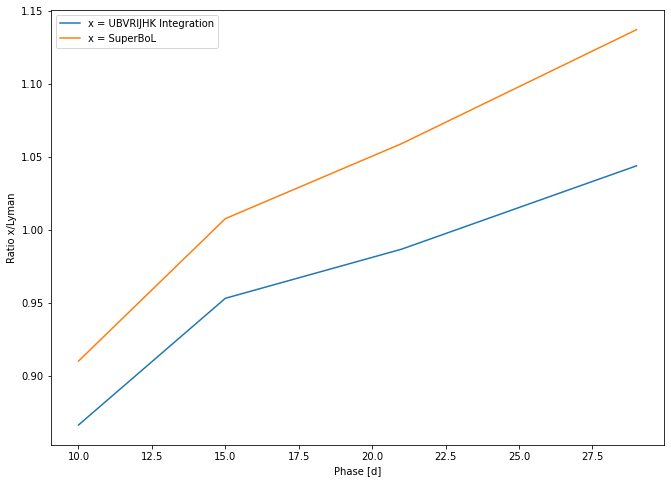

In [81]:
INS_VEGA = [
    #('U', 3492.67, 778.49, 3.58033e-9),
    #('B', 4377.97, 978.33, 6.44317e-9),
    #('V', 5439.64, 744.99, 3.72255e-9),
    #('R', 6457.54, 1298.29, 2.28509e-9),
    #('I', 8895.81, 3155.25, 9.19679e-10),
    ('U', 3610.30, 597.48, 3.93713e-9),
    ('B', 4360.79, 1041.07, 6.31306e-9),
    ('V', 5309.53, 1009.49, 3.98953e-9),
    ('R', 6632.62, 1509.99, 2.13438e-9),
    ('I', 8554.71, 2784.03, 1.00315e-9),
    ('J', 12536.58, 2886.97, 3.0717e-10),
    ('H', 16519.80, 2959.98, 1.14771e-10),
    ('K', 21638.30, 2745.48, 4.30954e-11)
]

INS=INS_VEGA
int_bands = [x[0] for x in INS]
cent_wave = [x[1] for x in INS]
fwhm = [x[2] for x in INS]
zero_flux = [x[3] for x in INS]

plt.figure(figsize=(11,8))
lum_int = np.empty(len(lum_lyman))
lum_superbol = np.empty(len(lum_lyman))
for i,row in enumerate(lc):
    mags = list(map(lambda band: row[band]-EXTINCTION_COEFF[band]*ebv, int_bands))
    #mag_errs = list(map(lambda band: row['e%s' % band]-EXTINCTION_COEFF[band]*ebv, int_bands))
    fluxes = np.array(zero_flux)*10**(-0.4*np.array(mags))
    flux_errs = np.abs(fluxes * -0.4 * np.log(10) * 0.02)
    
    # simple direction integration
    f_qbol = np.trapz(fluxes, cent_wave)
    lums_qbol = 4*np.pi*dist_cm**2*f_qbol
    lum_int[i] = lums_qbol
    
    # now do the superbol thing
    temperature, angular_radius, perr = bb_fit_parameters(cent_wave, fluxes, flux_errs)
    temperature_err = perr[0]
    angular_radius_err = perr[1]
    longest_wl = np.amax(cent_wave)
    shortest_wl = np.amin(cent_wave)
    shortest_flux = np.amin(fluxes)
    shortest_flux_err = np.amin(flux_errs)
    ir_corr, ir_corr_err = ir_correction(temperature, temperature_err, angular_radius, angular_radius_err, longest_wl)
    U_wl = cent_wave[0]
    U_flux = fluxes[0]
    if U_flux < bb_flux_nounits(U_wl, temperature, angular_radius):
        uv_corr, uv_corr_err = uv_correction_linear(
            shortest_wl, shortest_flux, shortest_flux_err)
    else:
        uv_corr, uv_corr_err = uv_correction_blackbody(
            temperature, temperature_err, angular_radius,
            angular_radius_err, shortest_wl)
    lum_superbol[i] = 4*np.pi*dist_cm**2*(f_qbol + ir_corr + uv_corr)
    
plt.plot(lc['time'], lum_int/lum_lyman, label='x = UBVRIJHK Integration')
plt.plot(lc['time'], lum_superbol/lum_lyman, label='x = SuperBoL')
plt.legend()
plt.xlabel('Phase [d]')
plt.ylabel('Ratio x/Lyman')